In [1]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils import get_device, train_clf, eval_clf, test_clf
from BertClassifier import BertClassifier, init_bert_clf


/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-21 12:01:19.734812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Analyze dataset

In [2]:
texts_df = pd.read_csv('subtaskB_train.csv')

In [3]:
texts_df.head()

,Id,comment_text,topic,conspiracy
0,0,"Siamo davanti ad una prova, e non solo di quoz...",Qanon,1
1,1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,Covid,0
2,2,L'avete capito che non toglieranno il green pa...,Covid,0
3,3,Quindi la farsa dello spazio e della terra a ...,Terra Piatta,3
4,4,"In breve tempo, per accedere a Internet, sarà ...",Qanon,1


In [4]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            810 non-null    int64 
 1   comment_text  810 non-null    object
 2   topic         810 non-null    object
 3   conspiracy    810 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 25.4+ KB


0 is Covid-Conspiracy,

1 is Qanon-Conspiracy,

2 is Flat Earth-Conspiracy,

3 is Pro-Russia Conspiracy.

0    435
1    242
3     76
2     57
Name: conspiracy, dtype: int64


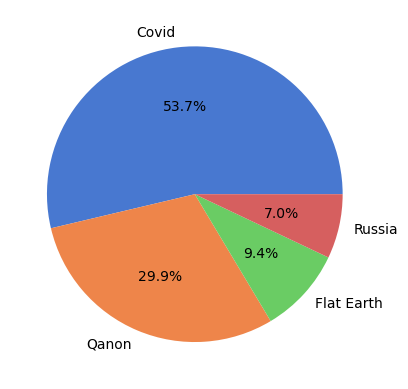

In [5]:
print(texts_df.conspiracy.value_counts())

palette = sns.color_palette('muted')
topic_labels = ['Covid', 'Qanon', 'Flat Earth', 'Russia']
plt.pie(texts_df.conspiracy.value_counts(), labels=topic_labels, autopct='%1.1f%%', colors=palette)
plt.show()

### Test set

In [6]:
texts_df_test = pd.read_csv('subtaskB_test.csv')
texts_df_test.head()

,Id,comment_text
0,0,Ho fatto delle foto aeree ad una quota di circ...
1,1,Prof. Bellavite: tantissime persone costrette ...
2,2,"Ma si allontana.... su una terra PIATTA,......"
3,3,Non tutti gli Ukraini sono contro la Russia.\n...
4,4,Non opinioni ma dati.\n\nUno strepitoso **Giov...


In [7]:
texts_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            300 non-null    int64 
 1   comment_text  300 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


## Preprocessing

Remove break line characthers

In [8]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))
texts_df_test.comment_text = texts_df_test.comment_text.apply(lambda text: str(text).replace('\n\n', ' ').replace('\n', ' '))


## Train-Validation split

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split of the labeled tr dataset

In [10]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiracy):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [11]:
print(train_df.info())
print(train_df.conspiracy.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 34 to 376
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            648 non-null    int64 
 1   comment_text  648 non-null    object
 2   topic         648 non-null    object
 3   conspiracy    648 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 25.3+ KB
None
0    348
1    193
3     61
2     46
Name: conspiracy, dtype: int64


In [12]:
print(val_df.info())
print(val_df.conspiracy.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 396 to 694
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            162 non-null    int64 
 1   comment_text  162 non-null    object
 2   topic         162 non-null    object
 3   conspiracy    162 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.3+ KB
None
0    87
1    49
3    15
2    11
Name: conspiracy, dtype: int64


## Tokenization

In [13]:
from transformers import BertTokenizer

In [14]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-italian-xxl-cased', do_lower_case=False)

In [15]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiracy'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiracy'].to_numpy()

texts_test = texts_df_test['comment_text']

Observe distribution of tokenized texts lengths by trying a simple tokenization on both tr and val sets.

Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


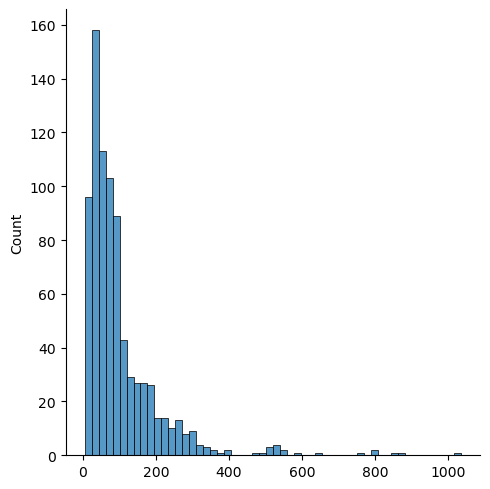

In [16]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

The maximum tokenized length is above the BERT max_lenght limit of 512. Very few texts are above this limit, so we truncate to 512

In [17]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

# Tr set
input_ids_tr = []
attention_masks_tr = []

# `encode_plus` will:
#   1. Tokenize the sentence, 2. Prepend the `[CLS]` token to the start, 3. Append the `[SEP]` token to the end
#   4. Map tokens to their IDs, 5. Pad or truncate the sentence to `max_length`, 6. Create attention masks for [PAD] tokens
for sentence in texts_tr:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_tr.append(encoded_dict['input_ids'])
    attention_masks_tr.append(encoded_dict['attention_mask'])

# Val set
input_ids_val = []
attention_masks_val = []

for sentence in texts_val:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

# Test set
input_ids_test = []
attention_masks_test = []

for sentence in texts_test:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
# Convert the lists into tensors

input_ids_tr = torch.cat(input_ids_tr, dim=0)
input_ids_val = torch.cat(input_ids_val, dim=0)
input_ids_test = torch.cat(input_ids_test, dim=0)

attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

## Generate DataLoaders

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Wrap data into a TensorDataset

In [20]:
tr_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

The DataLoader needs to know our batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [21]:
batch_size = 16

Create the DataLoaders for our training and validation sets. Tr samples are taken in random order, while validation are taken sequentially.

In [22]:
tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)

val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)

test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size = batch_size)

## Training Grid Search

In [23]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [24]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

Set save folder for this run

In [25]:
from datetime import datetime
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './checkpoints_bert_subtaskB/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.year, curr_date.hour, curr_date.minute)
if not os.path.exists(save_folder_pth):
    os.makedirs(save_folder_pth)

2023-04-20 22:21:17.881873


Fixed general hyperparams

In [26]:
max_epochs = 15


# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs

Variable grid searched hyperparams. Preliminary trials showed that classifications head with > 1 hidden layer failed to converge.

In [27]:
lr_list = [3e-6, 4e-6, 5e-6]
warmup_perc_list = [0.04, 0.08] # Percentage of warmup steps for scheduler on the total tr steps
clf_head_list = []

head1 = nn.Sequential(
              nn.Linear(768, 256),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(256, 4),
                )
clf_head_list.append((head1, '2_layers_M')) # Each head obeject is composed by a tuple (head, name)

head2 = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(512, 4),
                )
clf_head_list.append((head2, '2_layers_L')) 

head3 = nn.Sequential(
                nn.Linear(768, 1024),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(1024, 4),
                )
clf_head_list.append((head3, '2_layers_XL'))

Initialize, train/eval and save function for each grid search run

In [28]:
def train_eval_model(lr, warmup_steps, head, model_folder_pth, device):

    torch.cuda.empty_cache()
    #print(torch.cuda.memory_summary())

    # Initialize model
    bert_clf_model, loss_function, optimizer, scheduler = init_bert_clf(tr_steps=tr_steps, lr_rate=lr, scheduler_warmp_steps=warmup_steps, head=head)

    for epoch_i in range(max_epochs):
        print('Epoch: {}'.format(epoch_i))

        # Train
        avg_epoch_loss_tr, acc_score_tr, f1_score_tr, bert_clf_model, optimizer, scheduler = train_clf(bert_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)


        print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

        # Eval
        avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_clf(bert_clf_model, val_dataloader, loss_function, device)
        print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

        # Save
        model_save_pth = os.path.join(model_folder_pth, 'bert_clf_{}.pt'.format(epoch_i))
        torch.save({
                    'epoch': epoch_i,
                    'model_state_dict': bert_clf_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'schdeduler_state_dict': scheduler.state_dict(),
                    'tr_loss': avg_epoch_loss_tr,
                    'val_loss': avg_epoch_loss_val,
                    'tr_acc': acc_score_tr,
                    'val_acc': acc_score_val,
                    'tr_f1': f1_score_tr,
                    'val_f1': f1_score_val,
                    'val_preds': predictions
                    }, model_save_pth)

    torch.cuda.empty_cache()


Grid Search loop

In [29]:
num_trials = len(lr_list) * len(warmup_perc_list) * len(clf_head_list)
print('Executing {} trials in grid search'.format(num_trials))

for lr in lr_list:
    for clf_head_tuple in clf_head_list:
        for warmup_perc in warmup_perc_list:
            
            # Model save path subfolder
            model_folder_str = 'lr{}_warmup{}_head_{}'.format(lr, warmup_perc, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)
            if not os.path.exists(model_folder_pth):
                os.makedirs(model_folder_pth)

            print()
            print('Executing model with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, clf_head_tuple[1]))

            train_eval_model(lr, warmup_steps=warmup_perc*tr_steps, head=clf_head_tuple[0], model_folder_pth=model_folder_pth, device=device)

Executing 18 trials in grid search

Executing model with lr=3e-06, warmup perc.=0.04, head=2_layers_M


Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 1.1731515541309263 - Tr acc: 0.5246913580246914 - Tr f1: 0.17493133265513736
EVALUATION | Val Loss: 1.1097453019835732 - Val acc: 0.5370370370370371 - Val f1: 0.1746987951807229
Epoch: 1
TRAINING | Tr Loss: 1.0689370966539151 - Tr acc: 0.5432098765432098 - Tr f1: 0.18568123209899196
EVALUATION | Val Loss: 1.0474067005244168 - Val acc: 0.5555555555555556 - Val f1: 0.20567542213883677
Epoch: 2
TRAINING | Tr Loss: 0.9589223716317153 - Tr acc: 0.5817901234567902 - Tr f1: 0.25525564773233694
EVALUATION | Val Loss: 0.883041197603399 - Val acc: 0.6666666666666666 - Val f1: 0.39250972089612135
Epoch: 3
TRAINING | Tr Loss: 0.7567810169080409 - Tr acc: 0.7052469135802469 - Tr f1: 0.47988660580217557
EVALUATION | Val Loss: 0.634882547638633 - Val acc: 0.7962962962962963 - Val f1: 0.5896033354240041
Epoch: 4
TRAINING | Tr Loss: 0.5472498209011264 - Tr acc: 0.8256172839506173 - Tr f1: 0.6351613460069342
EVALUATION | Val Loss: 0.5256574235179208 - Val acc: 0.814814814814

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 1.1484305088112994 - Tr acc: 0.5354938271604939 - Tr f1: 0.1793185663744039
EVALUATION | Val Loss: 1.1015258106318386 - Val acc: 0.5370370370370371 - Val f1: 0.1746987951807229
Epoch: 1
TRAINING | Tr Loss: 0.9890363507154512 - Tr acc: 0.5725308641975309 - Tr f1: 0.23910372164721427
EVALUATION | Val Loss: 0.8451837409626354 - Val acc: 0.6481481481481481 - Val f1: 0.349248741346759
Epoch: 2
TRAINING | Tr Loss: 0.6553864268268027 - Tr acc: 0.7577160493827161 - Tr f1: 0.5534344123020691
EVALUATION | Val Loss: 0.5397848243063147 - Val acc: 0.8271604938271605 - Val f1: 0.6508642363293526
Epoch: 3
TRAINING | Tr Loss: 0.43580192036745025 - Tr acc: 0.8549382716049383 - Tr f1: 0.7370171282579073
EVALUATION | Val Loss: 0.4426313747059215 - Val acc: 0.8395061728395061 - Val f1: 0.697198731501057
Epoch: 4
TRAINING | Tr Loss: 0.30446432857978634 - Tr acc: 0.9104938271604939 - Tr f1: 0.8535319885343784
EVALUATION | Val Loss: 0.4185131368311969 - Val acc: 0.845679012345679

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 1.2209242335179957 - Tr acc: 0.4783950617283951 - Tr f1: 0.2804232499135048
EVALUATION | Val Loss: 1.116522404280576 - Val acc: 0.5493827160493827 - Val f1: 0.19572120346114152
Epoch: 1
TRAINING | Tr Loss: 1.0611073171220176 - Tr acc: 0.5570987654320988 - Tr f1: 0.2085903755522103
EVALUATION | Val Loss: 1.0162478577006946 - Val acc: 0.6172839506172839 - Val f1: 0.2922416639154837
Epoch: 2
TRAINING | Tr Loss: 0.9527782318068714 - Tr acc: 0.5879629629629629 - Tr f1: 0.2878550958374123
EVALUATION | Val Loss: 0.8562760786576704 - Val acc: 0.6728395061728395 - Val f1: 0.4967997951868919
Epoch: 3
TRAINING | Tr Loss: 0.7617884947032463 - Tr acc: 0.7345679012345679 - Tr f1: 0.5231588210505441
EVALUATION | Val Loss: 0.6491966518488798 - Val acc: 0.8395061728395061 - Val f1: 0.6490310934276452
Epoch: 4
TRAINING | Tr Loss: 0.5726762421247436 - Tr acc: 0.8040123456790124 - Tr f1: 0.6051420568107111
EVALUATION | Val Loss: 0.5285893190990795 - Val acc: 0.8271604938271605

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 1.1792446651109836 - Tr acc: 0.4660493827160494 - Tr f1: 0.23084673401881078
EVALUATION | Val Loss: 1.1012912880290637 - Val acc: 0.5246913580246914 - Val f1: 0.19669540229885057
Epoch: 1
TRAINING | Tr Loss: 0.949231413806357 - Tr acc: 0.6126543209876543 - Tr f1: 0.33209997435161387
EVALUATION | Val Loss: 0.744187821041454 - Val acc: 0.808641975308642 - Val f1: 0.6194345929640046
Epoch: 2
TRAINING | Tr Loss: 0.6304700832541396 - Tr acc: 0.7608024691358025 - Tr f1: 0.556774497807422
EVALUATION | Val Loss: 0.49381113865158777 - Val acc: 0.8333333333333334 - Val f1: 0.6464754053007248
Epoch: 3
TRAINING | Tr Loss: 0.4030338780182164 - Tr acc: 0.8780864197530864 - Tr f1: 0.7817078754578755
EVALUATION | Val Loss: 0.42554253204302356 - Val acc: 0.845679012345679 - Val f1: 0.7347640103420452
Epoch: 4
TRAINING | Tr Loss: 0.2665253950328362 - Tr acc: 0.9259259259259259 - Tr f1: 0.8861417275449903
EVALUATION | Val Loss: 0.3998927961696278 - Val acc: 0.8580246913580247

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 1.1964196679068775 - Tr acc: 0.4876543209876543 - Tr f1: 0.21754633115638852
EVALUATION | Val Loss: 1.1237139647657222 - Val acc: 0.5370370370370371 - Val f1: 0.1746987951807229
Epoch: 1
TRAINING | Tr Loss: 1.0780552465741227 - Tr acc: 0.5370370370370371 - Tr f1: 0.17947130342230225
EVALUATION | Val Loss: 1.061846218325875 - Val acc: 0.5370370370370371 - Val f1: 0.1746987951807229
Epoch: 2
TRAINING | Tr Loss: 0.9426663517951965 - Tr acc: 0.5817901234567902 - Tr f1: 0.2757991792914859
EVALUATION | Val Loss: 0.8138692704114047 - Val acc: 0.7654320987654321 - Val f1: 0.5759754625905068
Epoch: 3
TRAINING | Tr Loss: 0.6881558669776451 - Tr acc: 0.7623456790123457 - Tr f1: 0.5680643039440103
EVALUATION | Val Loss: 0.5818979685956781 - Val acc: 0.8024691358024691 - Val f1: 0.6371464093604557
Epoch: 4
TRAINING | Tr Loss: 0.48276492153725975 - Tr acc: 0.8364197530864198 - Tr f1: 0.6660516581709723
EVALUATION | Val Loss: 0.4992568384517323 - Val acc: 0.80246913580246

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 1.1149359011068576 - Tr acc: 0.5154320987654321 - Tr f1: 0.19318022655251502
EVALUATION | Val Loss: 1.0511830828406594 - Val acc: 0.5370370370370371 - Val f1: 0.1746987951807229
Epoch: 1
TRAINING | Tr Loss: 0.8150209086697277 - Tr acc: 0.6666666666666666 - Tr f1: 0.4354969273151091
EVALUATION | Val Loss: 0.5798164199699055 - Val acc: 0.8024691358024691 - Val f1: 0.6256313131313131
Epoch: 2
TRAINING | Tr Loss: 0.4429069793805843 - Tr acc: 0.8518518518518519 - Tr f1: 0.7530239887864609
EVALUATION | Val Loss: 0.4257951731031591 - Val acc: 0.8024691358024691 - Val f1: 0.7177417322040733
Epoch: 3
TRAINING | Tr Loss: 0.2854154237159869 - Tr acc: 0.9182098765432098 - Tr f1: 0.8795954071507515
EVALUATION | Val Loss: 0.3918446058576757 - Val acc: 0.8395061728395061 - Val f1: 0.7893625192012288
Epoch: 4
TRAINING | Tr Loss: 0.18736292876121474 - Tr acc: 0.9567901234567902 - Tr f1: 0.9329243452961545
EVALUATION | Val Loss: 0.363228823650967 - Val acc: 0.839506172839506

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 1.0370484009021665 - Tr acc: 0.5817901234567902 - Tr f1: 0.2611170191815353
EVALUATION | Val Loss: 0.7436147115447305 - Val acc: 0.7407407407407407 - Val f1: 0.5522058823529411
Epoch: 1
TRAINING | Tr Loss: 0.5574733073391566 - Tr acc: 0.8179012345679012 - Tr f1: 0.727041699537036
EVALUATION | Val Loss: 0.4265984012321992 - Val acc: 0.8518518518518519 - Val f1: 0.7816844919786097
Epoch: 2
TRAINING | Tr Loss: 0.2694271334060809 - Tr acc: 0.9228395061728395 - Tr f1: 0.8971002860811481
EVALUATION | Val Loss: 0.3754886341365901 - Val acc: 0.8765432098765432 - Val f1: 0.8410124544651583
Epoch: 3
TRAINING | Tr Loss: 0.16081783502567104 - Tr acc: 0.9614197530864198 - Tr f1: 0.9454366625845871
EVALUATION | Val Loss: 0.4489037665453824 - Val acc: 0.8641975308641975 - Val f1: 0.8030559835644582
Epoch: 4
TRAINING | Tr Loss: 0.08900146059146742 - Tr acc: 0.9830246913580247 - Tr f1: 0.9720434950805965
EVALUATION | Val Loss: 0.43042074821212073 - Val acc: 0.85802469135802

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 1.0455582432630586 - Tr acc: 0.5648148148148148 - Tr f1: 0.234859062170706
EVALUATION | Val Loss: 0.8166535550897772 - Val acc: 0.6975308641975309 - Val f1: 0.43642519559950754
Epoch: 1
TRAINING | Tr Loss: 0.5592741370201111 - Tr acc: 0.8271604938271605 - Tr f1: 0.7582319088735883
EVALUATION | Val Loss: 0.40454071489247406 - Val acc: 0.845679012345679 - Val f1: 0.819059563624781
Epoch: 2
TRAINING | Tr Loss: 0.26069021079598403 - Tr acc: 0.9228395061728395 - Tr f1: 0.906269695294699
EVALUATION | Val Loss: 0.35368203845891083 - Val acc: 0.8518518518518519 - Val f1: 0.7960817928841186
Epoch: 3
TRAINING | Tr Loss: 0.128811453764395 - Tr acc: 0.9645061728395061 - Tr f1: 0.9466945751113223
EVALUATION | Val Loss: 0.4288642555475235 - Val acc: 0.8580246913580247 - Val f1: 0.8272041512775654
Epoch: 4
TRAINING | Tr Loss: 0.06479456507396407 - Tr acc: 0.9861111111111112 - Tr f1: 0.9815376984126984
EVALUATION | Val Loss: 0.4166934236206792 - Val acc: 0.8580246913580247

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 1.0505948139400016 - Tr acc: 0.5478395061728395 - Tr f1: 0.2984280270891505
EVALUATION | Val Loss: 0.7125921899622137 - Val acc: 0.6851851851851852 - Val f1: 0.5014080901177675
Epoch: 1
TRAINING | Tr Loss: 0.5106468734944739 - Tr acc: 0.8225308641975309 - Tr f1: 0.7203961354992154
EVALUATION | Val Loss: 0.40372026508504694 - Val acc: 0.8580246913580247 - Val f1: 0.8221715109296182
Epoch: 2
TRAINING | Tr Loss: 0.24591166853177837 - Tr acc: 0.9274691358024691 - Tr f1: 0.9105856078538568
EVALUATION | Val Loss: 0.3258140209046277 - Val acc: 0.8827160493827161 - Val f1: 0.8594966955369552
Epoch: 3
TRAINING | Tr Loss: 0.1403285653852835 - Tr acc: 0.9598765432098766 - Tr f1: 0.9446628819736472
EVALUATION | Val Loss: 0.34737297282977536 - Val acc: 0.8827160493827161 - Val f1: 0.8650561317279504
Epoch: 4
TRAINING | Tr Loss: 0.08317367396340138 - Tr acc: 0.9753086419753086 - Tr f1: 0.9594765068664981
EVALUATION | Val Loss: 0.46604350344701245 - Val acc: 0.85802469135

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 1.016711207424722 - Tr acc: 0.558641975308642 - Tr f1: 0.2825942869221246
EVALUATION | Val Loss: 0.7073390917344526 - Val acc: 0.7592592592592593 - Val f1: 0.4827687420145723
Epoch: 1
TRAINING | Tr Loss: 0.4960077139662533 - Tr acc: 0.8240740740740741 - Tr f1: 0.7818755610156668
EVALUATION | Val Loss: 0.3783050233667547 - Val acc: 0.8518518518518519 - Val f1: 0.803399036264695
Epoch: 2
TRAINING | Tr Loss: 0.2477354754398509 - Tr acc: 0.9228395061728395 - Tr f1: 0.9103323990762368
EVALUATION | Val Loss: 0.32759661837057635 - Val acc: 0.845679012345679 - Val f1: 0.8177041690462592
Epoch: 3
TRAINING | Tr Loss: 0.12914823459052457 - Tr acc: 0.9660493827160493 - Tr f1: 0.9539363593011662
EVALUATION | Val Loss: 0.3572901101274924 - Val acc: 0.8641975308641975 - Val f1: 0.8285714285714287
Epoch: 4
TRAINING | Tr Loss: 0.05603282599959795 - Tr acc: 0.9861111111111112 - Tr f1: 0.9787342128739218
EVALUATION | Val Loss: 0.4677073500034484 - Val acc: 0.8703703703703703 

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.9632840142017458 - Tr acc: 0.6095679012345679 - Tr f1: 0.367935927067283
EVALUATION | Val Loss: 0.5792012079195543 - Val acc: 0.8024691358024691 - Val f1: 0.623667228226497
Epoch: 1
TRAINING | Tr Loss: 0.42258504196638014 - Tr acc: 0.8487654320987654 - Tr f1: 0.7966724485617847
EVALUATION | Val Loss: 0.3611689033833417 - Val acc: 0.845679012345679 - Val f1: 0.8026542894452962
Epoch: 2
TRAINING | Tr Loss: 0.2144516828220065 - Tr acc: 0.9274691358024691 - Tr f1: 0.9154092660825177
EVALUATION | Val Loss: 0.4288409108465368 - Val acc: 0.8641975308641975 - Val f1: 0.8106437278568426
Epoch: 3
TRAINING | Tr Loss: 0.10999475860195916 - Tr acc: 0.9660493827160493 - Tr f1: 0.9524087630634485
EVALUATION | Val Loss: 0.4325123998251828 - Val acc: 0.8641975308641975 - Val f1: 0.7970461190855929
Epoch: 4
TRAINING | Tr Loss: 0.05623311826550379 - Tr acc: 0.9845679012345679 - Tr f1: 0.9732165066592404
EVALUATION | Val Loss: 0.4051744809204882 - Val acc: 0.8703703703703703

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.9547291717878202 - Tr acc: 0.6049382716049383 - Tr f1: 0.3437399467468838
EVALUATION | Val Loss: 0.5993974804878235 - Val acc: 0.808641975308642 - Val f1: 0.6182620768594866
Epoch: 1
TRAINING | Tr Loss: 0.44209789848182257 - Tr acc: 0.8580246913580247 - Tr f1: 0.8364154380180822
EVALUATION | Val Loss: 0.34921334006569604 - Val acc: 0.8765432098765432 - Val f1: 0.8380924090740554
Epoch: 2
TRAINING | Tr Loss: 0.23176623199407648 - Tr acc: 0.9243827160493827 - Tr f1: 0.9204878278023219
EVALUATION | Val Loss: 0.3202420655976642 - Val acc: 0.8765432098765432 - Val f1: 0.8538433908045977
Epoch: 3
TRAINING | Tr Loss: 0.13602648720872113 - Tr acc: 0.9552469135802469 - Tr f1: 0.9509759925577188
EVALUATION | Val Loss: 0.3885329772125591 - Val acc: 0.8703703703703703 - Val f1: 0.8231934731934731
Epoch: 4
TRAINING | Tr Loss: 0.056142995247571936 - Tr acc: 0.9876543209876543 - Tr f1: 0.9777149174144882
EVALUATION | Val Loss: 0.4020058417862112 - Val acc: 0.87654320987

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.808279330228887 - Tr acc: 0.6759259259259259 - Tr f1: 0.4904127130091151
EVALUATION | Val Loss: 0.46983041817491705 - Val acc: 0.8333333333333334 - Val f1: 0.6909629077661865
Epoch: 1
TRAINING | Tr Loss: 0.31985279681479056 - Tr acc: 0.8858024691358025 - Tr f1: 0.8566281963700211
EVALUATION | Val Loss: 0.2976981157606298 - Val acc: 0.8580246913580247 - Val f1: 0.8239811912225705
Epoch: 2
TRAINING | Tr Loss: 0.1325349499039897 - Tr acc: 0.9567901234567902 - Tr f1: 0.9423171405683471
EVALUATION | Val Loss: 0.45852736925536935 - Val acc: 0.8703703703703703 - Val f1: 0.8356182098965421
Epoch: 3
TRAINING | Tr Loss: 0.059108513532342706 - Tr acc: 0.9814814814814815 - Tr f1: 0.9791543604345687
EVALUATION | Val Loss: 0.47944919764995575 - Val acc: 0.8641975308641975 - Val f1: 0.8248900830483634
Epoch: 4
TRAINING | Tr Loss: 0.026643789100756005 - Tr acc: 0.9953703703703703 - Tr f1: 0.9922584853858636
EVALUATION | Val Loss: 0.5529969246550039 - Val acc: 0.864197530

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.934882310832419 - Tr acc: 0.6111111111111112 - Tr f1: 0.3810174802458154
EVALUATION | Val Loss: 0.513201583515514 - Val acc: 0.7962962962962963 - Val f1: 0.7539147956246401
Epoch: 1
TRAINING | Tr Loss: 0.4003088001797839 - Tr acc: 0.8533950617283951 - Tr f1: 0.8373360550340748
EVALUATION | Val Loss: 0.3954335627230731 - Val acc: 0.8333333333333334 - Val f1: 0.8002335236118319
Epoch: 2
TRAINING | Tr Loss: 0.1799783753004016 - Tr acc: 0.9429012345679012 - Tr f1: 0.9379189603335786
EVALUATION | Val Loss: 0.34316962550986896 - Val acc: 0.8703703703703703 - Val f1: 0.8432183908045978
Epoch: 3
TRAINING | Tr Loss: 0.07825505544953956 - Tr acc: 0.9799382716049383 - Tr f1: 0.968349201183625
EVALUATION | Val Loss: 0.37686574222012 - Val acc: 0.8765432098765432 - Val f1: 0.8379378858957618
Epoch: 4
TRAINING | Tr Loss: 0.022796036039547222 - Tr acc: 0.9938271604938271 - Tr f1: 0.9911487340522179
EVALUATION | Val Loss: 0.5140915350480513 - Val acc: 0.8765432098765432 

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.870294254364037 - Tr acc: 0.6188271604938271 - Tr f1: 0.47242094703341997
EVALUATION | Val Loss: 0.43750877949324524 - Val acc: 0.8395061728395061 - Val f1: 0.8095017098192476
Epoch: 1
TRAINING | Tr Loss: 0.3603356854944694 - Tr acc: 0.8734567901234568 - Tr f1: 0.8535865564059228
EVALUATION | Val Loss: 0.5029148743911223 - Val acc: 0.8271604938271605 - Val f1: 0.8085587975243149
Epoch: 2
TRAINING | Tr Loss: 0.17569951654025695 - Tr acc: 0.9475308641975309 - Tr f1: 0.9407028606619601
EVALUATION | Val Loss: 0.35927399146285927 - Val acc: 0.8641975308641975 - Val f1: 0.8345496680702942
Epoch: 3
TRAINING | Tr Loss: 0.06621432261223473 - Tr acc: 0.9891975308641975 - Tr f1: 0.9905936402217965
EVALUATION | Val Loss: 0.4301403415474025 - Val acc: 0.8765432098765432 - Val f1: 0.8395563238259869
Epoch: 4
TRAINING | Tr Loss: 0.020545003833476363 - Tr acc: 0.9969135802469136 - Tr f1: 0.9956510645662671
EVALUATION | Val Loss: 0.4701048830016093 - Val acc: 0.8765432098

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.862116656652311 - Tr acc: 0.6373456790123457 - Tr f1: 0.44668625505706094
EVALUATION | Val Loss: 0.44679299809715967 - Val acc: 0.8271604938271605 - Val f1: 0.7180173564753004
Epoch: 1
TRAINING | Tr Loss: 0.3871629388957489 - Tr acc: 0.8611111111111112 - Tr f1: 0.8407486434733656
EVALUATION | Val Loss: 0.36083485321565106 - Val acc: 0.8580246913580247 - Val f1: 0.8486461970774033
Epoch: 2
TRAINING | Tr Loss: 0.17597404381305706 - Tr acc: 0.9351851851851852 - Tr f1: 0.9156638383439251
EVALUATION | Val Loss: 0.3833376155658202 - Val acc: 0.8765432098765432 - Val f1: 0.8188095210918209
Epoch: 3
TRAINING | Tr Loss: 0.06019029591982139 - Tr acc: 0.9845679012345679 - Tr f1: 0.9800709348123141
EVALUATION | Val Loss: 0.4362845414064147 - Val acc: 0.8580246913580247 - Val f1: 0.8307201008793742
Epoch: 4
TRAINING | Tr Loss: 0.021123148642889247 - Tr acc: 0.9938271604938271 - Tr f1: 0.9935860335054513
EVALUATION | Val Loss: 0.4712551517242735 - Val acc: 0.8580246913

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.7785253152251244 - Tr acc: 0.6975308641975309 - Tr f1: 0.5621766810118365
EVALUATION | Val Loss: 0.5244079774076288 - Val acc: 0.8271604938271605 - Val f1: 0.6964984205217413
Epoch: 1
TRAINING | Tr Loss: 0.3118311409361479 - Tr acc: 0.8811728395061729 - Tr f1: 0.8581984278074729
EVALUATION | Val Loss: 0.39166771552779456 - Val acc: 0.8580246913580247 - Val f1: 0.8019853709508882
Epoch: 2
TRAINING | Tr Loss: 0.12033685158211284 - Tr acc: 0.9645061728395061 - Tr f1: 0.9541586952390346
EVALUATION | Val Loss: 0.3939855301922018 - Val acc: 0.8765432098765432 - Val f1: 0.8369557645419714
Epoch: 3
TRAINING | Tr Loss: 0.043705793838698145 - Tr acc: 0.9922839506172839 - Tr f1: 0.988432022203535
EVALUATION | Val Loss: 0.4731744780120524 - Val acc: 0.8888888888888888 - Val f1: 0.8500698635821633
Epoch: 4
TRAINING | Tr Loss: 0.021710140301232656 - Tr acc: 0.9953703703703703 - Tr f1: 0.9922584853858636
EVALUATION | Val Loss: 0.5411354469304736 - Val acc: 0.88271604938

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

Epoch: 0
TRAINING | Tr Loss: 0.8289365237805901 - Tr acc: 0.6620370370370371 - Tr f1: 0.49278401428878693
EVALUATION | Val Loss: 0.43020521239800885 - Val acc: 0.8271604938271605 - Val f1: 0.7686358470095155
Epoch: 1
TRAINING | Tr Loss: 0.3125967970345078 - Tr acc: 0.8935185185185185 - Tr f1: 0.8935534117913259
EVALUATION | Val Loss: 0.39706274325197394 - Val acc: 0.8703703703703703 - Val f1: 0.7972839449259328
Epoch: 2
TRAINING | Tr Loss: 0.1535311438961 - Tr acc: 0.9490740740740741 - Tr f1: 0.9224996395750811
EVALUATION | Val Loss: 0.36998287808488717 - Val acc: 0.8827160493827161 - Val f1: 0.8488498970879164
Epoch: 3
TRAINING | Tr Loss: 0.052262109610615524 - Tr acc: 0.9861111111111112 - Tr f1: 0.9814928786515088
EVALUATION | Val Loss: 0.517715261741118 - Val acc: 0.8765432098765432 - Val f1: 0.8362992033739456
Epoch: 4
TRAINING | Tr Loss: 0.018245781309016777 - Tr acc: 0.9969135802469136 - Tr f1: 0.9956510645662671
EVALUATION | Val Loss: 0.5431685921820727 - Val acc: 0.870370370370

## Analyze grid search results

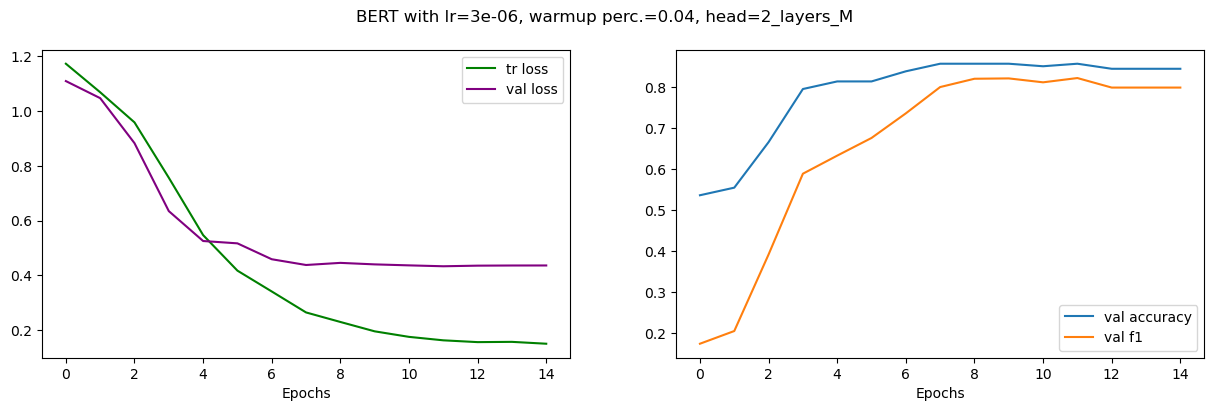

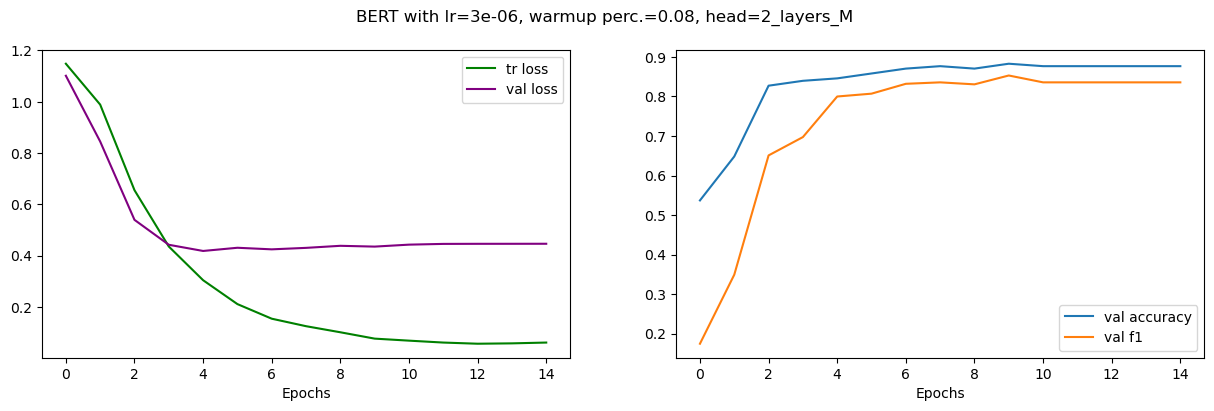

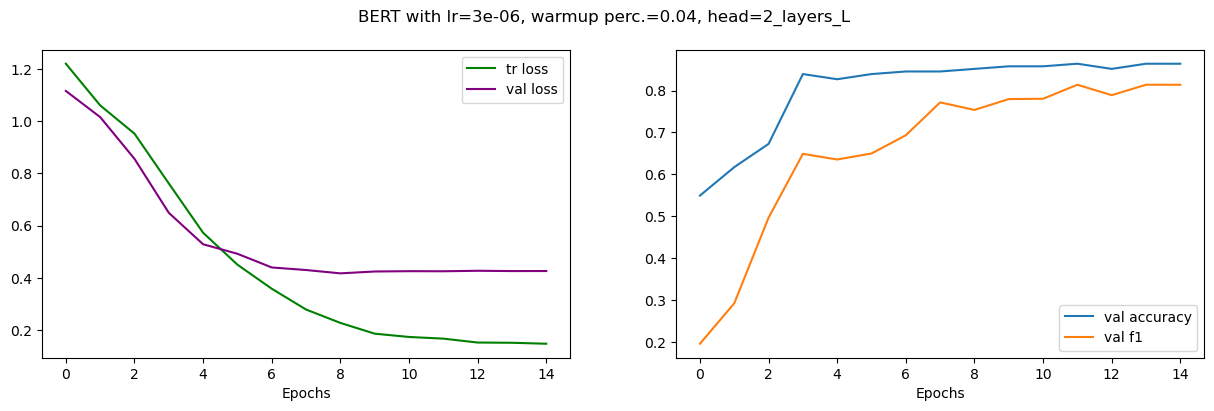

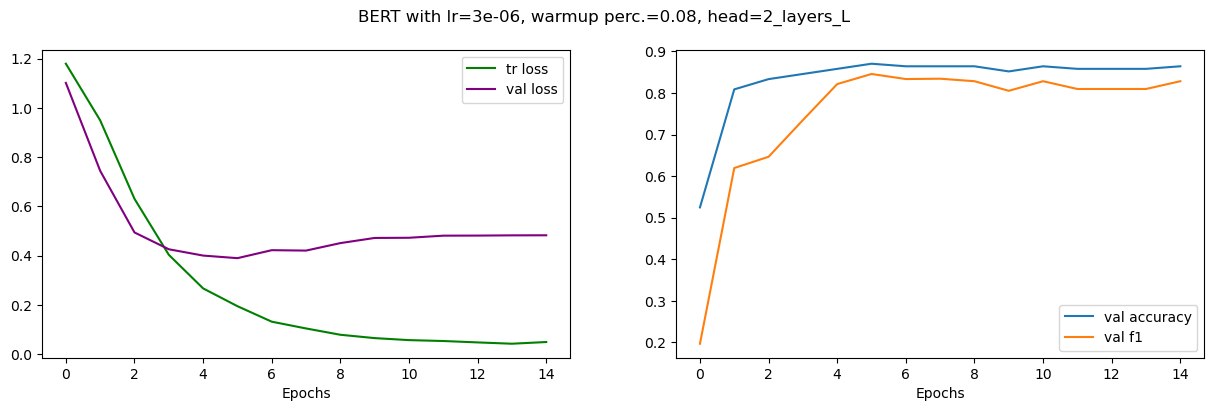

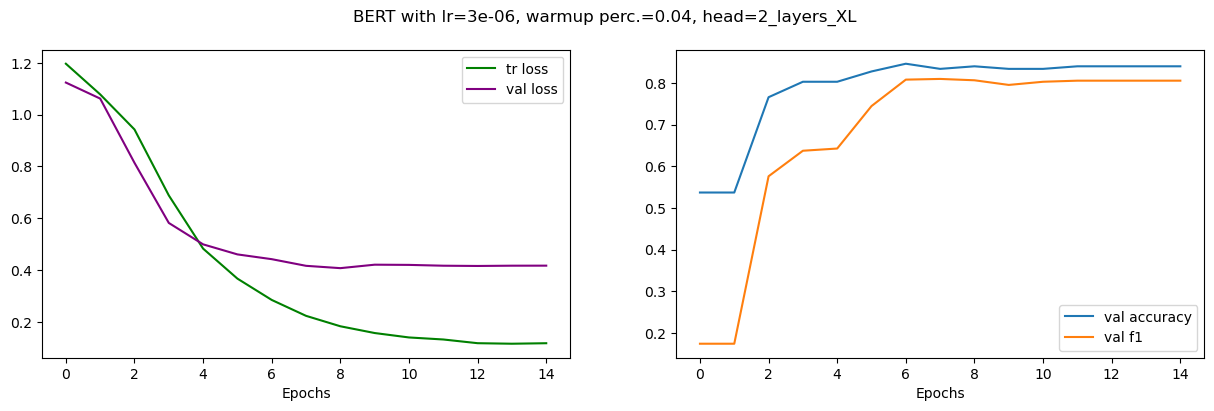

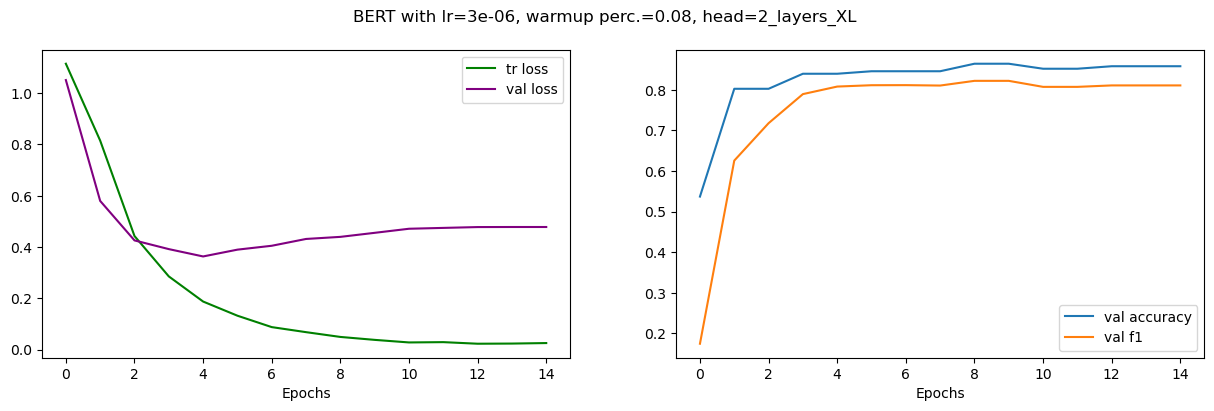

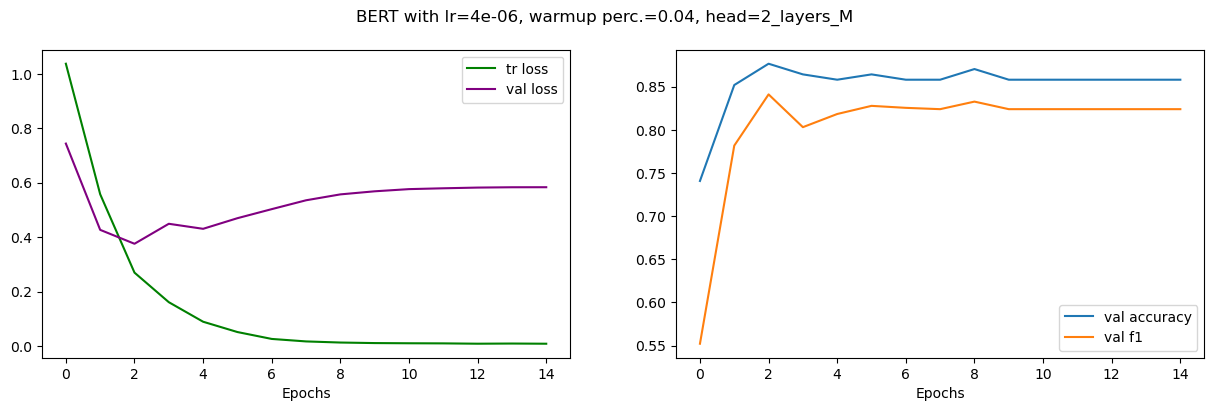

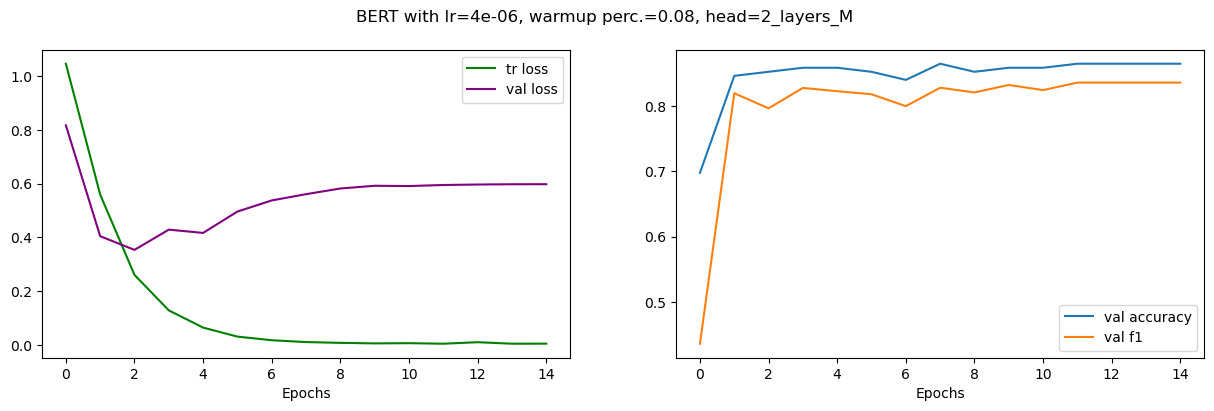

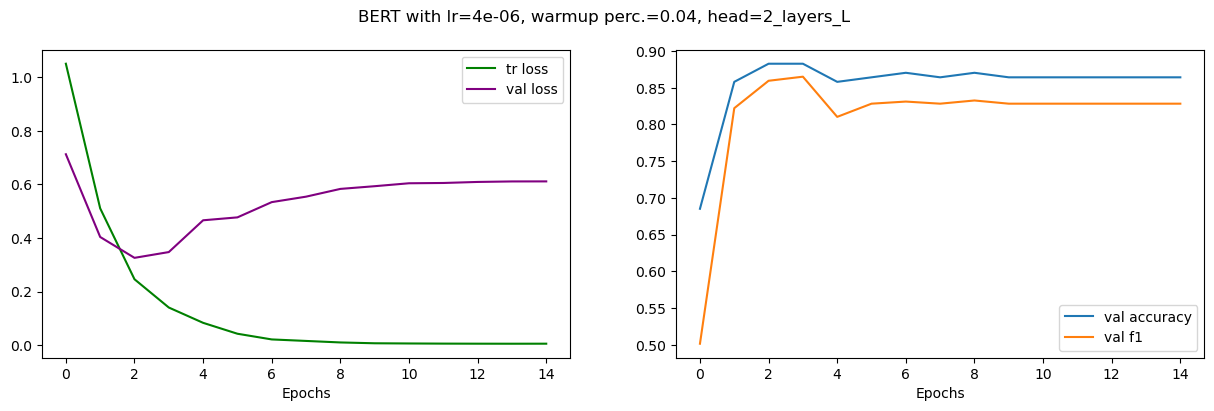

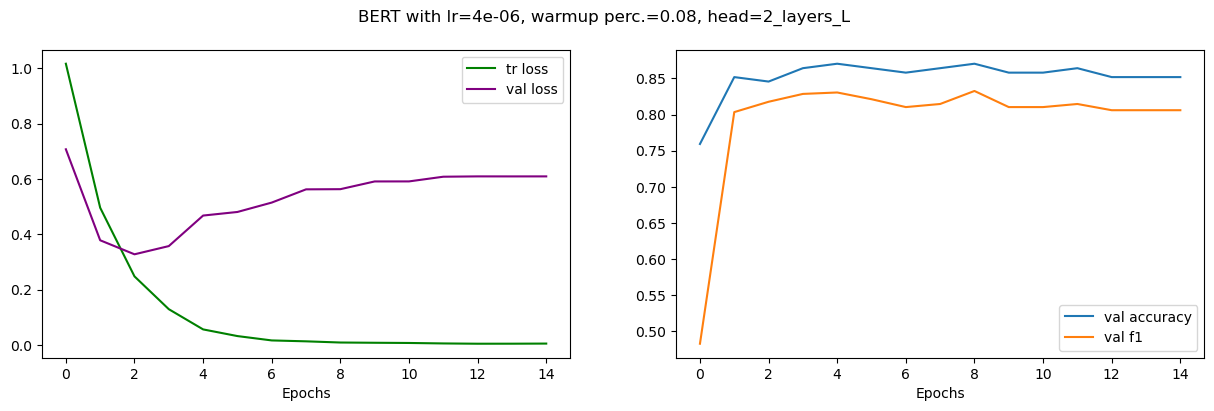

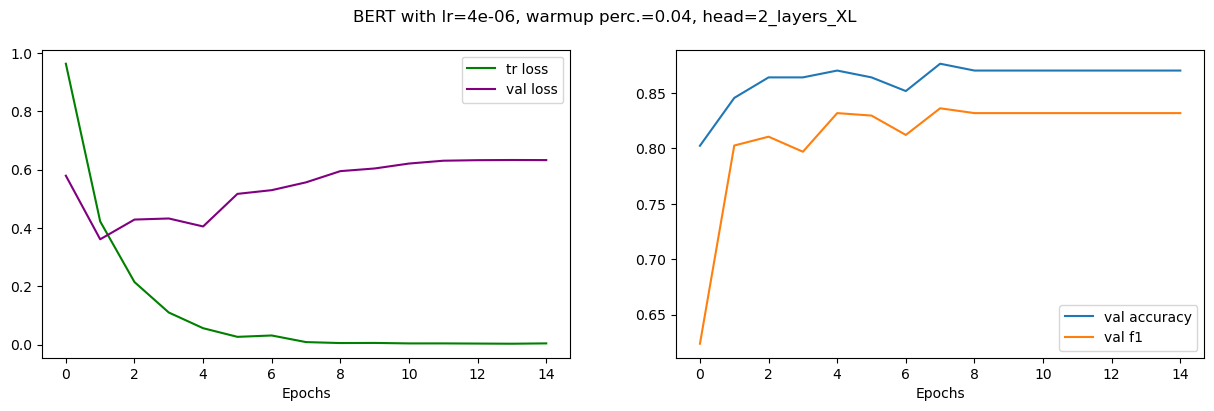

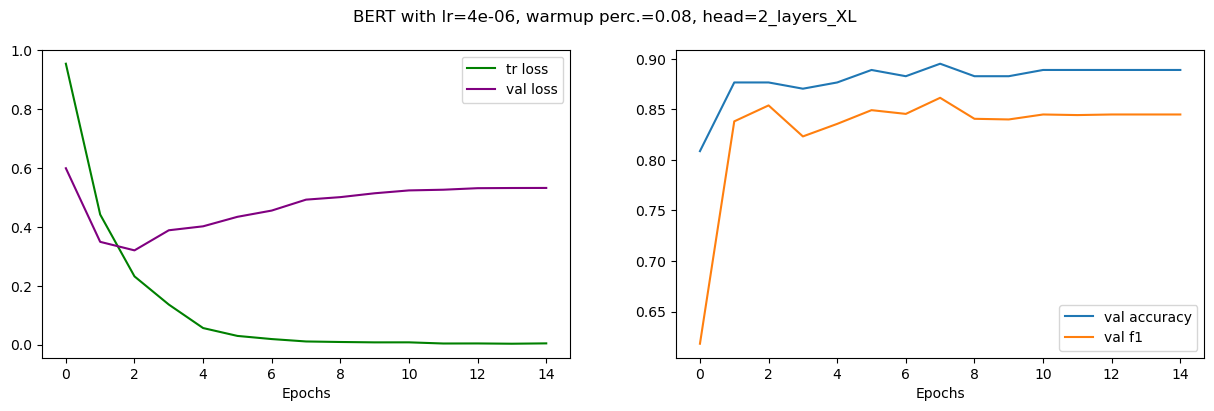

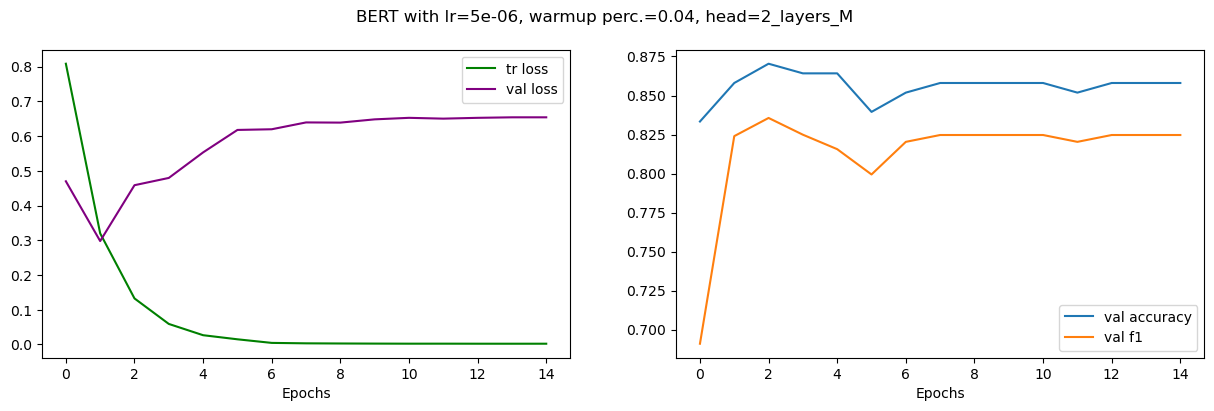

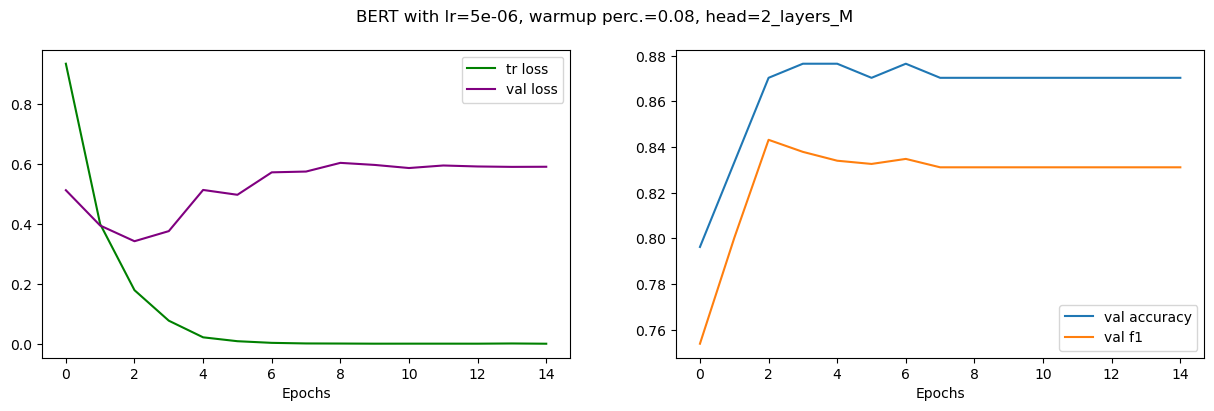

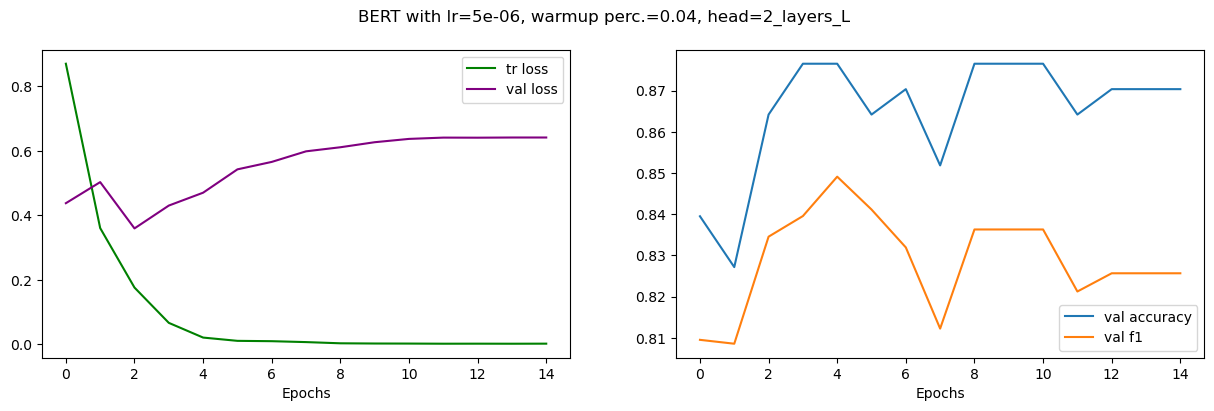

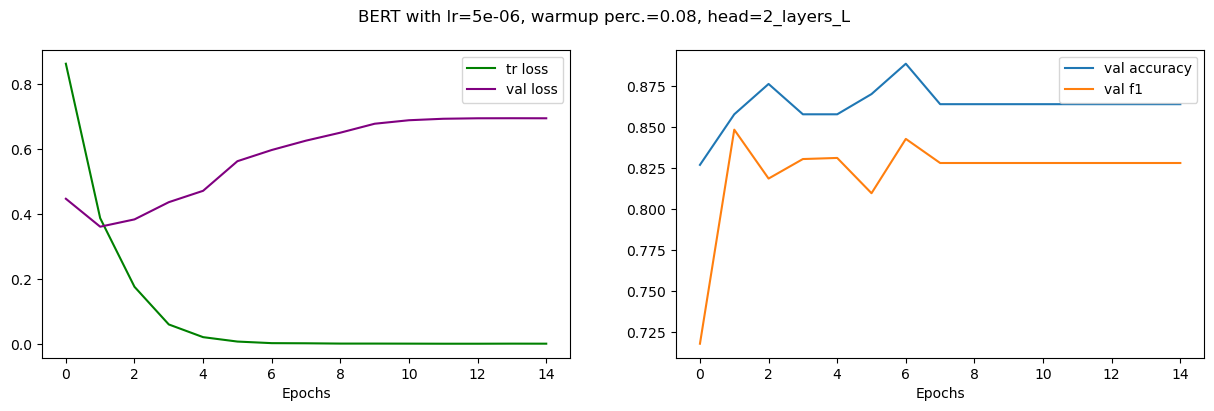

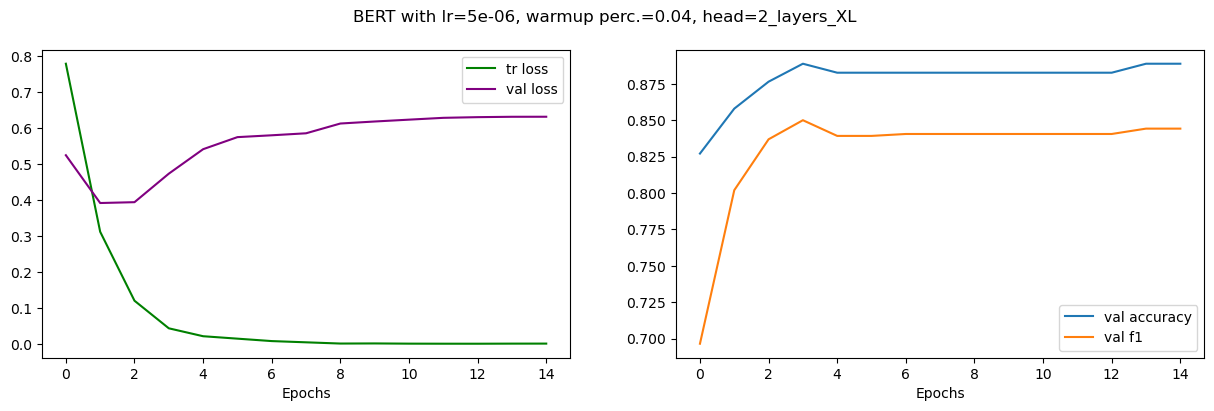

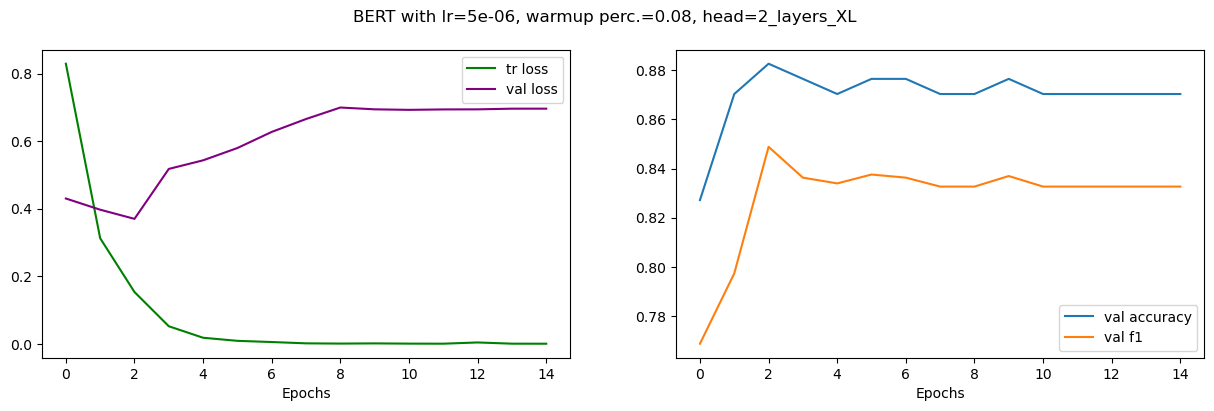

In [40]:
save_folder_pth = './checkpoints_bert_subtaskB/20_4_2023-22.21' # Grid search run to analyze

best_f1_list = []

for lr in lr_list:
    for clf_head_tuple in clf_head_list:
        for warmup_perc in warmup_perc_list:
            
            # Model path subfolder
            model_folder_str = 'lr{}_warmup{}_head_{}'.format(lr, warmup_perc, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)

            title = 'BERT with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, clf_head_tuple[1])

            # Load model checkpoint for each epoch
            val_loss_list, tr_loss_list, val_f1_list, val_acc_list = [], [], [], []

            for epoch_i in range(max_epochs):
                model_pth = os.path.join(model_folder_pth,'bert_clf_{}.pt'.format(epoch_i))
                checkpoint = torch.load(model_pth)
                val_loss_list.append(checkpoint['val_loss'])
                tr_loss_list.append(checkpoint['tr_loss'])
                val_f1_list.append(checkpoint['val_f1'])
                val_acc_list.append(checkpoint['val_acc'])


            best_f1 = max(val_f1_list)
            best_epoch = val_f1_list.index(best_f1)
            best_f1_list.append((title, best_epoch, best_f1))


            plt.figure(figsize=(15,4))

            plt.subplot(1, 2, 1)
            plt.plot(tr_loss_list, label='tr loss', color='green')
            plt.plot(val_loss_list, label='val loss', color='purple')
            plt.xlabel('Epochs')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(val_acc_list, label='val accuracy')
            plt.plot(val_f1_list, label='val f1')
            plt.xlabel('Epochs')
            plt.legend()

            plt.suptitle(title)
            plt.show()

In [41]:
for title, epoch, f1 in best_f1_list:
    print('{} at epoch {}, F1: {:.4f}'.format(title, epoch, f1))

BERT with lr=3e-06, warmup perc.=0.04, head=2_layers_M at epoch 11, F1: 0.8231
BERT with lr=3e-06, warmup perc.=0.08, head=2_layers_M at epoch 9, F1: 0.8529
BERT with lr=3e-06, warmup perc.=0.04, head=2_layers_L at epoch 11, F1: 0.8140
BERT with lr=3e-06, warmup perc.=0.08, head=2_layers_L at epoch 5, F1: 0.8457
BERT with lr=3e-06, warmup perc.=0.04, head=2_layers_XL at epoch 7, F1: 0.8092
BERT with lr=3e-06, warmup perc.=0.08, head=2_layers_XL at epoch 8, F1: 0.8220
BERT with lr=4e-06, warmup perc.=0.04, head=2_layers_M at epoch 2, F1: 0.8410
BERT with lr=4e-06, warmup perc.=0.08, head=2_layers_M at epoch 11, F1: 0.8354
BERT with lr=4e-06, warmup perc.=0.04, head=2_layers_L at epoch 3, F1: 0.8651
BERT with lr=4e-06, warmup perc.=0.08, head=2_layers_L at epoch 8, F1: 0.8327
BERT with lr=4e-06, warmup perc.=0.04, head=2_layers_XL at epoch 7, F1: 0.8363
BERT with lr=4e-06, warmup perc.=0.08, head=2_layers_XL at epoch 7, F1: 0.8614
BERT with lr=5e-06, warmup perc.=0.04, head=2_layers_M at

## Choose and predict on test with best model

Best model is: BERT with lr=4e-06, warmup perc.=0.04, head=2_layers_L at epoch 3, with a macro average F1 of 0.8651

In [32]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [33]:
final_model_pth = './checkpoints_bert_subtaskB/20_4_2023-22.21/lr4e-06_warmup0.04_head_2_layers_L/bert_clf_3.pt'

# Recover the best head configuration
head_2_layers_L = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(512, 4),
                )
# Initialize and recover model checkpoint
final_model = BertClassifier(head=head_2_layers_L)
final_model.load_state_dict(torch.load(final_model_pth).get('model_state_dict'))

final_model.to(device)

# Prediction on test
test_preds = test_clf(final_model, test_dataloader, device)

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
print(test_preds)
# print occurrences of each class
print(np.unique(test_preds, return_counts=True))

[3, 0, 3, 2, 0, 3, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 1, 0, 1, 0, 1, 0, 3, 0, 1, 3, 1, 2, 0, 1, 0, 1, 1, 0, 1, 3, 3, 1, 3, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 1, 3, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 3, 3, 1, 0, 0, 1, 1, 3, 0, 1, 2, 3, 1, 0, 3, 0, 1, 0, 1, 2, 0, 1, 1, 3, 0, 1, 0, 1, 0, 1, 0, 0, 0, 3, 1, 1, 0, 0, 1, 2, 0, 3, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 3, 0, 3, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 1, 3, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 3, 3, 1, 1, 0, 0, 3, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 3, 3, 0, 0, 1, 3, 0, 0, 0, 1, 3, 1, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 3, 0, 0, 1, 0, 3, 0, 3, 3, 3, 2, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 2, 1, 0, 1, 1, 3, 1, 0, 2, 0, 3, 3, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 3, 3, 1, 3, 1]
(array([0, 1, 2, 3]), array([154,  80,  19,  47]))


Generate result CSV

In [35]:
id_list = [i for i in range(len(test_preds))]
df = pd.DataFrame({'Id': id_list, 'Expected': test_preds})
df.to_csv('final_bert_submission_B.csv', index=False)

**RESULTS FROM KAGGLE:**

-On the 50% available hidden test set it scores **0.80218**  F1 macro averaged

-On the full hidden test set it scores **0.8508**  F1 macro averaged